##### **NLP - HW2 - Part2**
##### Student name: **Majid Adibian**
##### Student number: **400131078**

##### connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### download data

In [ ]:
!gdown --id 1Px1lQhMgkdeFigxwmqvk1ojJPZpq40u5 
!gdown --id 1WHbpY1Ydqq7yqtQ2YFavR78zsD7nDwbg 
!gdown --id 1pMJQk75R3898sUzFKUMQTPPE_QlllvAY

!gdown --id 1NMesvM67oiJ6-PpSbtErFanj0JMl_Z50
!unzip vectors.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Px1lQhMgkdeFigxwmqvk1ojJPZpq40u5
To: /content/UPC_2016_train.txt
100% 25.4M/25.4M [00:00<00:00, 127MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1WHbpY1Ydqq7yqtQ2YFavR78zsD7nDwbg
To: /content/UPC_2016_val.txt
100% 5.47M/5.47M [00:00<00:00, 183MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...

##### import libraries

In [ ]:
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model

import random
import pickle
import matplotlib.pyplot as plt

main_path = '/content/drive/MyDrive/Colab Notebooks/NLP_HWs/HW2/'

### Step 1:

##### reade word vector

In [ ]:
def create_words_vec(path):
    f = open(path, 'r', encoding='UTF-8')
    lines = f.readlines()
    f.close()
    word2vec = {}
    for line in lines:
        tokens = line.split()
        word = tokens[0]
        vec = np.array(tokens[1:]).astype('float')
        word2vec[word] = vec
    word2vec['PAD'] = np.zeros(list(word2vec.values())[0].shape)
    word2vec['OOV'] = np.ones(list(word2vec.values())[0].shape)

    return word2vec

word2vec = create_words_vec('vectors.txt')

##### extract words and tags sequences and convert them to matrixes

In [ ]:
def read_data(path, params, is_train):
    f = open(path, 'r', encoding='UTF-8')
    lines = f.readlines()
    f.close()
    input_data = []
    target_data = []
    input_seq = []
    target_seq = []
    for line in lines:
        if line.strip():
            splited = line.split()
            input_seq.append(splited[0])
            target_seq.append(splited[1])
        else:
            input_data.append(input_seq)
            target_data.append(target_seq)
            input_seq = []
            target_seq = []
    input_data2 = []
    target_data2 = []
    step = params['step'] if is_train else params['window_len']
    for i in range(len(input_data)):
        for j in range(0, len(input_data[i]), step):
            input_data2.append(input_data[i][j:j+params['window_len']])
            target_data2.append(target_data[i][j:j+params['window_len']])
        input_data2[-1] = input_data[i][-params['window_len']:]
        target_data2[-1] = target_data[i][-params['window_len']:]
    del input_data
    del target_data
    return input_data2, target_data2

def create_data(path, word2vec, params=None, is_train=True):
    input_data, target_data = read_data(path, params, is_train)
    if not is_train:
        max_input_length = params['max_input_length']
        max_target_length = params['max_target_length']
        word_vec_length = params['word_vec_length']
    else:
        max_input_length = len(max(input_data, key=len))
        max_target_length = len(max(target_data, key=len))
        word_vec_length = len(list(word2vec.values())[0])
    for i in range(len(input_data)):
        seq = input_data[i]
        pad_seq = ['PAD' for _ in range(max_input_length-len(seq))]
        input_data[i].extend(pad_seq)
    input_matrix = np.zeros((len(input_data), max_input_length, word_vec_length), dtype="float16")
    target_matrix = np.zeros((len(target_data), max_target_length), dtype="int8")
    if is_train:
        tag2id = {'PAD':0}
    else:
        tag2id = params['tag2id']
    for i in range(len(input_data)):
        for j, w in enumerate(input_data[i]):
            if w in word2vec.keys():
                input_matrix[i][j] = word2vec[w]
            else:
                input_matrix[i][j] = word2vec['OOV']
        for j, w in enumerate(target_data[i]):
            if w in tag2id.keys():
                target_matrix[i][j] = tag2id[w]
            else:
                tag2id[w] = len(tag2id.keys())-1
                target_matrix[i][j] = tag2id[w]
    if is_train:
        id2tag = {id: tag for tag, id in tag2id.items()}
        params.update({'id2tag': id2tag, 'tag2id': tag2id, 'max_input_length': max_input_length, 'max_target_length': max_target_length, 'word_vec_length': word_vec_length})
    return input_matrix, target_matrix, params

In [ ]:
params = {'window_len': 6, 'step': 2}
train_input_matrix, train_target_matrix, params = create_data('UPC_2016_train.txt', word2vec, params, True)
val_input_matrix, val_target_matrix, _ = create_data('UPC_2016_val.txt', word2vec, params, False)
test_input_matrix, test_target_matrix, _ = create_data('UPC_2016_test.txt', word2vec, params, False)

##### create model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 6, 256)           183296    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 6, 31)            7967      
 tributed)                                                       
                                                                 
 activation_1 (Activation)   (None, 6, 31)             0         
                                                                 
Total params: 191,263
Trainable params: 191,263
Non-trainable params: 0
_________________________________________________________________


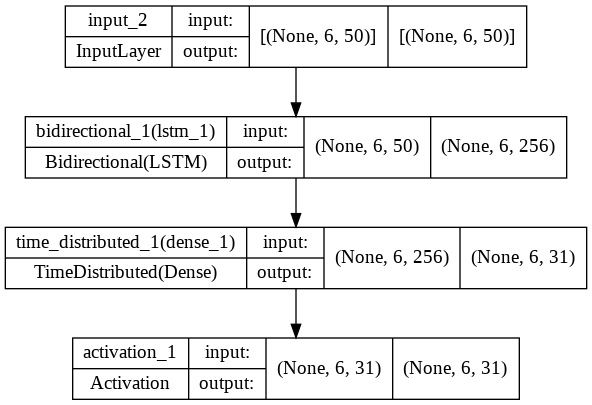

In [ ]:
model = Sequential()
model.add(Input(shape=(params['max_input_length'], params['word_vec_length'])))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(len(params['tag2id']))))
model.add(Activation('softmax'))
 
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##### train model

In [ ]:
history = model.fit(train_input_matrix, train_target_matrix, batch_size=1024, epochs=15, shuffle=True, validation_data=(val_input_matrix, val_target_matrix))
model.save(main_path + "model.h5")
with open(main_path+'history.p', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/15
909/909 [==============================] - 22s 20ms/step - loss: 0.6635 - accuracy: 0.8040 - val_loss: 0.3984 - val_accuracy: 0.8781
Epoch 2/15
909/909 [==============================] - 16s 17ms/step - loss: 0.3224 - accuracy: 0.9028 - val_loss: 0.2860 - val_accuracy: 0.9136
Epoch 3/15
909/909 [==============================] - 16s 18ms/step - loss: 0.2525 - accuracy: 0.9238 - val_loss: 0.2421 - val_accuracy: 0.9270
Epoch 4/15
909/909 [==============================] - 16s 17ms/step - loss: 0.2195 - accuracy: 0.9333 - val_loss: 0.2175 - val_accuracy: 0.9342
Epoch 5/15
909/909 [==============================] - 16s 18ms/step - loss: 0.1996 - accuracy: 0.9390 - val_loss: 0.2012 - val_accuracy: 0.9384
Epoch 6/15
909/909 [==============================] - 16s 18ms/step - loss: 0.1859 - accuracy: 0.9429 - val_loss: 0.1894 - val_accuracy: 0.9417
Epoch 7/15
909/909 [==============================] - 16s 17ms/step - loss: 0.1758 - accuracy: 0.9457 - val_loss: 0.1818 - val_accuracy:

### Step 2:

##### plot accuracy and loss

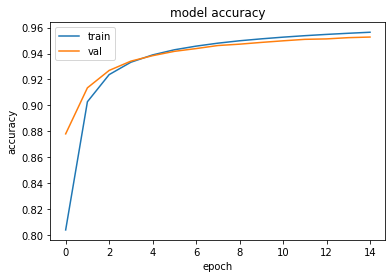

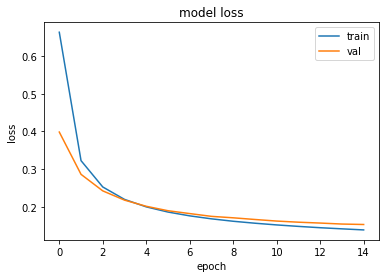

In [ ]:
def plot_train_info(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

plot_train_info(main_path+'history.p')

##### use test data to evaluate

In [ ]:
def evaluate_model(test_input_matrix, test_target_matrix, id2tag, model=None):
    if not model:
        model = models.load_model(main_path + "model.h5")
    all_predicted = model.predict(test_input_matrix)
    confusion_matrix = {true_tag: {pred_tag:0 for pred_tag in id2tag.values() if pred_tag != 'PAD'}  for true_tag in id2tag.values() if true_tag != 'PAD'}
    true_predicted = 0
    all_tokens = 0
    for i, pred_tags in enumerate(all_predicted):
        true_tags = test_target_matrix[i]
        for j, pred_tag_vec in enumerate(pred_tags):
            pred_tag = np.argmax(pred_tag_vec)
            true_tag = true_tags[j]
            confusion_matrix[id2tag[true_tag]][id2tag[pred_tag]] += 1
            all_tokens += 1
            if true_tag == pred_tag:
                true_predicted += 1
    accuracy = true_predicted/all_tokens

    return confusion_matrix, accuracy

confusion_matrix, accuracy = evaluate_model(test_input_matrix, test_target_matrix, params['id2tag'])

##### calculate accuracy in test data and precision and recall in any tags

In [ ]:
print('accuracy: ' + str(accuracy))
print()

precision = {}
recall = {}
tags = list(confusion_matrix.keys())
for tag in tags:
    r = confusion_matrix[tag][tag]/sum(confusion_matrix[tag].values())
    p = confusion_matrix[tag][tag]/sum([confusion_matrix[t][tag] for t in tags])
    precision[tag] = round(p, 3)
    recall[tag] = round(r, 3)
for tag in tags:
    print(tag + ': ')
    print('\t precision: ' + str(precision[tag]))
    print('\t recall: ' + str(recall[tag]))

accuracy: 0.9518710581639804

DELM: 
	 precision: 0.881
	 recall: 0.952
NUM: 
	 precision: 0.87
	 recall: 0.877
N_SING: 
	 precision: 0.97
	 recall: 0.956
P: 
	 precision: 0.988
	 recall: 0.991
N_PL: 
	 precision: 0.951
	 recall: 0.934
V_PP: 
	 precision: 0.966
	 recall: 0.963
V_PRS: 
	 precision: 0.971
	 recall: 0.965
CON: 
	 precision: 0.993
	 recall: 0.985
PRO: 
	 precision: 0.979
	 recall: 0.947
ADJ_SUP: 
	 precision: 0.979
	 recall: 0.934
ADJ: 
	 precision: 0.906
	 recall: 0.926
CLITIC: 
	 precision: 1.0
	 recall: 1.0
V_PA: 
	 precision: 0.97
	 recall: 0.968
DET: 
	 precision: 0.945
	 recall: 0.971
SYM: 
	 precision: 0.854
	 recall: 0.648
ADV_LOC: 
	 precision: 0.956
	 recall: 0.905
V_AUX: 
	 precision: 0.965
	 recall: 0.926
V_SUB: 
	 precision: 0.949
	 recall: 0.942
ADV_TIME: 
	 precision: 0.915
	 recall: 0.922
ADJ_CMPR: 
	 precision: 0.943
	 recall: 0.844
ADV_I: 
	 precision: 0.881
	 recall: 0.908
ADJ_INO: 
	 precision: 0.781
	 recall: 0.521
ADV: 
	 precision: 0.842
	 recall: 0.

##### plot confusion matrix 

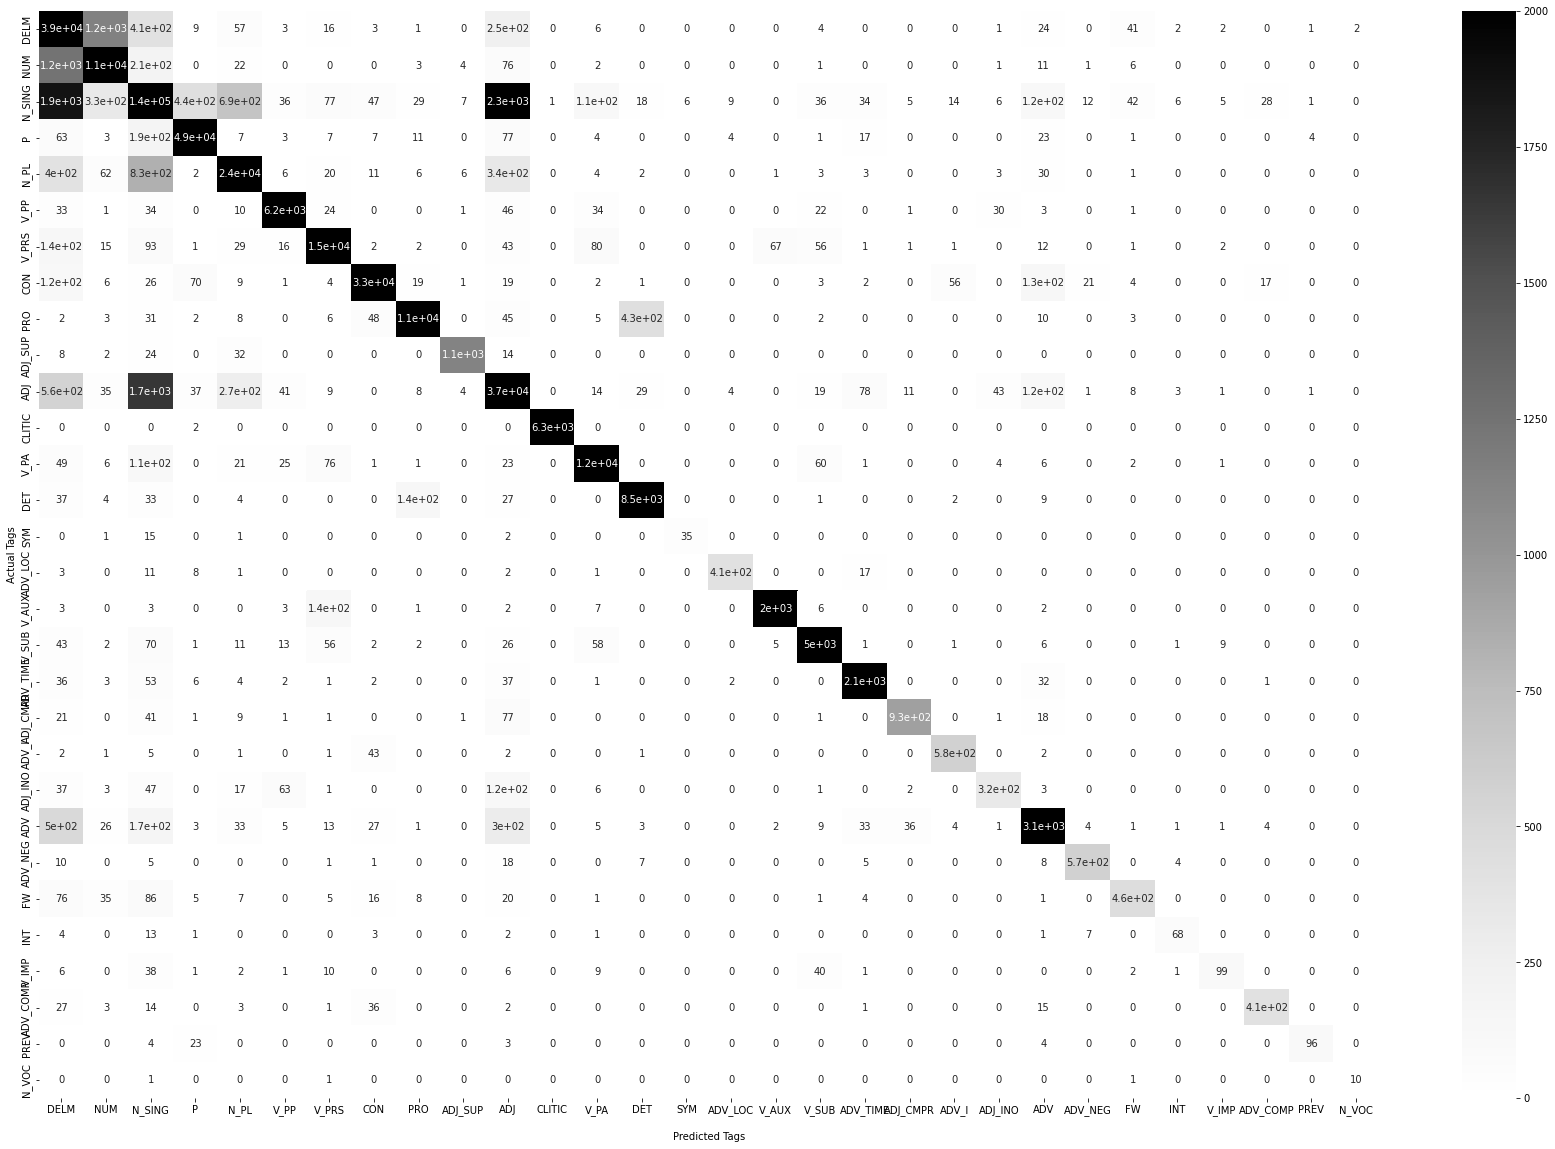

In [ ]:
import seaborn as sns

tags = confusion_matrix.keys()
confusion_matrix_as_array = [[confusion_matrix[t1][t2] for t2 in tags] for t1 in tags]
plt.figure(figsize = (30,20))
ax = sns.heatmap(confusion_matrix_as_array, cmap='Greys', annot=True, vmax=2000)
ax.set_xlabel('\nPredicted Tags')
ax.set_ylabel('Actual Tags');

ax.xaxis.set_ticklabels(tags)
ax.yaxis.set_ticklabels(tags)
plt.show()

##### find tags that are most false predicted

In [ ]:
tags = list(confusion_matrix.keys())
for tag1 in tags:
    for tag2 in tags:
        if tag1 != tag2 and confusion_matrix[tag1][tag2] > 0:
            false_negative = confusion_matrix[tag1][tag2]/sum(confusion_matrix[tag1].values())
            if false_negative > 0.15:
                print('true tag: {0}  ,   predicted tag: {1}'.format(tag1, tag2))


true tag: SYM  ,   predicted tag: N_SING
true tag: ADJ_INO  ,   predicted tag: ADJ
true tag: V_IMP  ,   predicted tag: N_SING
true tag: V_IMP  ,   predicted tag: V_SUB
true tag: PREV  ,   predicted tag: P
